# Uniper Country Classification

In [1]:
import pickle
from datetime import date
from pathlib import Path
import zipfile
from zipfile import ZipFile
import dill as pkl
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

TODAY = date.today().strftime("%Y%m%d")
CLIENT = "Uniper"
MIN_NUM_OF_SAMPLES = 5
COUNTRY = 'ALL'
SAVE_CLFS = True
RES_DIR = Path("./retraining_october21/")
SCAN_ID_COL = "filename"  # document identifier col used when reducing global df to relevant examples for attribute

In [2]:
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [3]:
# %load training_utils.py
"""This file contains helper functionality to train/evaluate models
   and create reports"""

import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions


def reduce_to_relevant(df: DataFrame, col: str, min_num_samples: int) -> DataFrame:
    """Reduces df to instances with values in col that appear at least
       min_num_samples times and returns reduced df.

    Args:
        df (DataFrame): Input DataFrame.
        col (str): Name of the column that holds the feature of interest.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'col'
            that appear more than 'min_num_samples' times.

    """
    # find rows for values that appear at least min_num_samples times
    relevant = [x for x in df[col].value_counts().index
                if df[col].value_counts()[x] >= min_num_samples]
    # create boolean mask
    mask = [(x in relevant) for x in df[col]]

    print(
        f"Reduced to {len(df[mask])} samples from {len(relevant)} relevant classes. (N={min_num_samples})"
    )

    return df[mask]


def get_reduced_df(
        df: DataFrame,
        feature_col: str,
        scan_id_col: str,
        min_num_samples: int) -> DataFrame:
    """Drops duplicates and reduces df to relevant examples that appear
       at least min_num_samples times and are unambiguous.

    Args:
        df (DataFrame): Input DataFrame.
        feature_col (str): Name of the column that holds the feature of interest.
        scan_id_col (str): Name of the column that holds the unique
            document identifier.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'feature_col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'feature_col'
            that appear more than 'min_num_samples' times and are unambiguous.

    """
    # keep only documents with unambiguous value for this col
    df_ = df.drop_duplicates(subset=[scan_id_col, feature_col])\
            .groupby(scan_id_col)\
            .filter(lambda x: len(x) == 1)

    return reduce_to_relevant(df_, feature_col, min_num_samples)


def split_for_target_col(df, col, test_size=0.2, random_state=42):
    """
    Performs train test split with specified col as target variable.
    Returns: X_train, X_test, y_train, y_test
    """
    return train_test_split(
        df,
        df[col],
        test_size=test_size,
        random_state=random_state
    )


def _get_top_n_results_with_confs(
        clazzes: Sequence[str],
        probs: List[float],
        n: int = 1) -> List[Tuple[str, float]]:
    """Constructs list of (class, proba) tuples for top n results.

    Args:
        clazzes (Sequence[str]): Sequence of class names as stored in
            clf.classes_ attribute of sklearn classifier.
        probs (List[float]): List with probabilities for each class in clazzes.
        n (int): Number of most probable results to return. Defaults to 1.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for top n results.

    """
    return sorted(
        zip(clazzes, probs),
        key=lambda x: x[1],
        reverse=True
    )[:n]


def get_results_for_target(
        target_clf: Any,
        df: DataFrame) -> List[Tuple[str, float]]:
    """Computes predictions with provided classifier on DataFrame df.

    Args:
        target_clf (Any): Sklearn classifier that offers 'predict_proba()'.
        df (DataFrame): Input DataFrame as expected by 'target_clf'.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for
            instances in df.

    """
    probs = target_clf.predict_proba(df)
    clazzes = target_clf.classes_
    results = []
    for prob_list in probs:
        results.append(_get_top_n_results_with_confs(clazzes, prob_list)[0])
    return results


def _get_text_col_from_df(df: DataFrame):
    return df['text']


def create_model() -> Pipeline:
    """Creates new sklearn Pipeline instance with TfidfVectorizer and
       RandomForestClassifier.
    Returns:
        Pipeline: Sklearn Pipeline instance with TfidfVectorizer and
           RandomForestClassifier.

    """
    vectorizer = TfidfVectorizer(
        max_features=20000,
        max_df=0.75,
        sublinear_tf=True,
    )
    ranfor = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        # max_depth=20,
    )

    get_text_data = FunctionTransformer(
        _get_text_col_from_df,
        validate=False,
    )

    clf_pipe = Pipeline(
        [
            (
                'tfidf_features', Pipeline(
                    [
                        ('get_text_data', get_text_data),
                        ('vect', vectorizer)
                    ]
                )
            ),
            ('clf', ranfor)
        ]
    )
    return clf_pipe


def evaluate_model(
        clf: Any,
        x_test: np.array,
        y_test: Sequence,
        report: bool = True) -> Optional[Dict[str, str]]:
    """
    Evaluates model on test set and prints accuracy as well as
    full classification report.
    Optionally returns report as dict for further processing into word files.
    """
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy is {acc}.")
    if report:
        rep = classification_report(y_test, y_pred)
        print("\n" + "CLASSIFICATION REPORT:" + "\n")
        print(rep)
        return classification_report(y_test, y_pred, output_dict=True)

    return None


def create_hist(
        clf: Any,
        clf_name: str,
        x_test: np.array,
        folder: Path,
        date: str,
        client: str,
        country: str,
        min_num_samples: int):
    """
    Creates and saves histogram over prediction probabilities for provided test data.
    """
    probas = clf.predict_proba(x_test)
    max_values = np.max(probas, axis=1)
    plt.hist(max_values, bins=10, range=(0, 1), density=True)
    plt.title(clf_name)
    plt.xlabel('Confidence')
    plt.ylabel('Probability Density')
    plt.savefig(folder / f'{date}_{client}_hist_{country}_{clf_name}_N_{min_num_samples}.png')


def create_excel_file_with_test_predictions(
        clf,
        attribute_name: str,
        x_test,
        y_test,
        folder: Path,
        date: str,
        client: str,
        country: str,
        min_num_samples: int):

    target_results = get_results_for_target(clf, x_test)
    results_dict = {
        attribute_name: y_test,
        f'{attribute_name}_pred': [res for res, _ in target_results],
        'confidence': [conf for _, conf in target_results],
        'filename': x_test['filename'].tolist()
    }

    results_df = pd.DataFrame.from_dict(results_dict)

    results_df.to_excel(
        folder / f'{date}_{client}_results_with_conf_{country}_{attribute_name}_N_{min_num_samples}.xlsx',
        index=False
    )


def create_word_from_report(
        date,
        client,
        country,
        name,
        rep_dict,
        min_num_samples,
        folder: Path,
        excel=False) -> None:
    # set correct values for accuracy row
    rep_dict['accuracy'] = {
        'precision': "",
        'recall': "",
        'f1-score': rep_dict['accuracy'],
        'support': rep_dict['macro avg']['support']}
    # number of classes (last three rows are summary statistics)
    num_classes = len(rep_dict) - 3
    # convert to pandas df and order colums
    rep = pd.DataFrame(rep_dict).transpose()
    rep = rep[['precision', 'recall', 'f1-score', 'support']]

    # insert empty row to match look of notebook print
    df1 = rep[0:-3]
    df2 = rep[-3:]
    df1.loc[len(df1)] = 4*[""]
    idx = list(df1.index)
    idx[-1] = ""
    df1 = df1.reindex(idx)
    rep = pd.concat([df1, df2])
    rep.fillna("", inplace=True)

    doc_name = f'{date}_{client}_Classification_{country}_{name}_N_{min_num_samples}'

    if excel:
        rep.to_excel(folder / (doc_name + '.xlsx'), index=True)

    # create word document
    document = Document()

    document.add_heading(f'{client}: {country} Invoices', 0)

    document.add_heading(name, level=1)

    document.add_paragraph(
        f'\n{num_classes} verschiedene Einträge, für die {min_num_samples} oder mehr Beispiele vorhanden sind.\n'
    )
    # add a table and create a reference variable
    # extra row is so we can add the header row
    # extra col for index
    table = document.add_table(rows=rep.shape[0]+1, cols=rep.shape[1]+1)

    # add the header rows.
    for j in range(rep.shape[1]):
        table.cell(0, j+1).text = rep.columns[j]

    # add index, put in empty row before averages
    for row in range(rep.shape[0]):
        table.cell(row+1, 0).text = rep.index[row]

    # add the rest of the data frame
    for row in range(rep.shape[0]):
        for col in range(rep.shape[-1]):
            val = rep.values[row, col]
            # support col
            if col == rep.shape[-1]-1:
                if isinstance(val, str):
                    table.cell(row+1, col+1).text = val
                else:
                    table.cell(row+1, col+1).text = str(int(val))
            # everything else
            elif isinstance(val, str):
                table.cell(row+1, col+1).text = val
            else:
                table.cell(row+1, col+1).text = "%.2f" % val

    document.save(folder / (doc_name + '.docx'))


def save_clf_to_disk(
        clf,
        attribute_name: str,
        folder: Path,
        date: str,
        client: str,
        country: str,
        min_num_samples: int,
        add_zip=True) -> None:

    # safe to pkl with full info in file name
    pkl_path = folder / f"{date}_{client}_clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl"
    with open(pkl_path, 'wb') as file:
        pkl.dump(clf, file)

    if add_zip:
        # create zip with non changing name for easy deployment
        zip_path = folder / f"clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl.zip"
        with ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as file:
            # second argument avoids recreation of folder structure in zip-archive
            file.write(pkl_path, pkl_path.parts[-1])


def train_clf_and_create_reports(
        df: DataFrame,
        attribute_name: str,
        scan_id_col: str,
        folder: Path,
        date: str,
        client: str,
        country: str,
        min_num_samples: int,
        histogram: bool = True,
        word_report: bool = True,
        predictions_excel: bool = False,
        save_clf: bool = True,
        verbose: bool = True) -> None:

    if verbose:
        print(10*"-", f" start training for attribute: {attribute_name} ", 10*"-", "\n")

    # filter df for attribute
    df_attr = get_reduced_df(df, attribute_name, scan_id_col, min_num_samples)

    # perform split
    x_train, x_test, y_train, y_test = split_for_target_col(df_attr, attribute_name)

    # train model
    clf = create_model()
    clf.fit(x_train, y_train)
    report = evaluate_model(clf, x_test, y_test)

    if histogram:
        create_hist(
            clf,
            attribute_name,
            x_test,
            folder,
            date,
            client,
            country,
            min_num_samples
        )
        if verbose:
            print(10*"-", " created histogram ", 10*"-", "\n")

    if word_report:
        create_word_from_report(
            date,
            client,
            country,
            attribute_name,
            report,
            min_num_samples,
            folder,
            excel=False
        )
        if verbose:
            print(10*"-", " created word report ", 10*"-", "\n")

    if predictions_excel:
        create_excel_file_with_test_predictions(
            clf,
            attribute_name,
            x_test,
            y_test,
            folder,
            date,
            client,
            country,
            min_num_samples
        )
        if verbose:
            print(10*"-", " created predictions excel file ", 10*"-", "\n")

    if save_clf:
        save_clf_to_disk(
            clf,
            attribute_name,
            folder,
            date,
            client,
            country,
            min_num_samples,
            add_zip=True
        )
        if verbose:
            print(10*"-", " saved clf to pkl and zip ", 10*"-", "\n")

    if verbose:
        print(10*"-", f" finished training for attribute: {attribute_name} ", 10*"-")


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tday = date.today().strftime("%A %d. %B %Y") 
print(f"Models trained on {tday} with package versions: \n")
print(f"scikit-learn: {sklearn.__version__}")
print(f"dill: {pkl.__version__}")

Models trained on Friday 22. October 2021 with package versions: 

scikit-learn: 0.24.0
dill: 0.3.1.1


In [6]:
# dict used to enrich ground truth later
country_to_country_group = {
    "DE": 'de',
    "SE": 'se',
    "AT": 'at',
    "GB": 'uk',
    "BE": 'ubx',
    "NL": 'ubx',
    "LU": 'ubx'   
}

# Load Ground Truth And Merge OCR Texts

In [7]:
df_ground_truth = pd.read_excel("Uniper_GT_09_21.xlsx")
df_ground_truth.dropna(subset=['gl_document_scan_id'], inplace=True)
df_ground_truth["gl_document_scan_id"] = df_ground_truth["gl_document_scan_id"].apply(lambda x: x.lower())
len(df_ground_truth)

108347

In [8]:
# with open(f"ocr_text_uniper_nonPO_2020.pkl", 'rb') as file:  
#     df_lume = pickle.load(file)

# with open("uniper_txts_2020_Q2.pkl", 'rb') as file:  
#     df_lume_new = pickle.load(file)
    
# df_lume = pd.concat([df_lume, df_lume_new], ignore_index=True)

# df_lume["filename"] = df_lume["filename"].apply(lambda fn: fn.split("_")[-1])
# df_lume["filename"] = df_lume["filename"].apply(lambda filename: filename.lower())

with open("texts_all_rt202110.pkl", "rb") as file:
    df_lume = pickle.load(file)

In [9]:
df_merged = df_lume.merge(df_ground_truth, left_on=["filename"], right_on=["gl_document_scan_id"], how="inner")

In [10]:
df_merged["country"] = df_merged['le_country_id'].apply(lambda x: country_to_country_group[x])

In [11]:
df_merged["country"].value_counts()

de     47313
se     36580
ubx     4684
uk      3829
at      2429
Name: country, dtype: int64

# Load and Merge Old OCR Texts

For the October 2021 Training, we have to merge older OCR extractions with new 2020 data.

In [12]:
df_lume = df_merged
print(df_lume.shape, "\n")

for country in ["de", "at", "uk", "se", "ubx"]:
    with open(f"ocr_text_df_{country}.pkl", 'rb') as file:  
        df_lume_country = pickle.load(file)
    df_lume_country["country"] = country
    print(f"shape {country}: {df_lume_country.shape}\n")
    df_lume = pd.concat([df_lume, df_lume_country], ignore_index=True)

print(f"Total shape: {df_lume.shape}")

(94835, 57) 

shape de: (23618, 3)

shape at: (478, 3)

shape uk: (7865, 3)

shape se: (22014, 3)

shape ubx: (4629, 3)

Total shape: (153439, 57)


In [13]:
df_lume = df_lume[["filename", "text", "country", "gl_posting_id"]]
df_lume.head()

,filename,text,country,gl_posting_id
0,000d3a2c37f81eda88f70ad52d38ce1c,gedruckt auf „steinbeis innojet premiui ausge...,de,40.0
1,000d3a2c37f81eda88f70adcd822ee1c,el: { n 1 )) } ad l dds conferencing & caterin...,de,40.0
2,000d3a2c37f81eda88f70ab0ea394e1c,zimmermann hauschild notare lubmin-brandov ga...,de,40.0
3,000d3a2c37f81eea8cd4c4aa57e474ed,rechnung uniper global commodities se rechnun...,de,40.0
4,000d3a2c37f81eda88f70aafcad7ee1c,= as fri it til vinr fre „> bundesnetzagent...,de,40.0


In [14]:
# some cleaning
df_lume["filename"] = df_lume["filename"].apply(lambda filename: filename.lower())
df_lume = df_lume[df_lume["text"] != 0]
df_lume = df_lume[df_lume["text"] != '']
df_lume["text"] = df_lume["text"].apply(lambda text: str(text).replace("\r\n", " ").replace("\n", " ").lower())
df_lume.dropna(subset=['text'], inplace=True)
df_lume.drop_duplicates(inplace=True)
df_lume.head()

,filename,text,country,gl_posting_id
0,000d3a2c37f81eda88f70ad52d38ce1c,gedruckt auf „steinbeis innojet premiui ausge...,de,40.0
1,000d3a2c37f81eda88f70adcd822ee1c,el: { n 1 )) } ad l dds conferencing & caterin...,de,40.0
2,000d3a2c37f81eda88f70ab0ea394e1c,zimmermann hauschild notare lubmin-brandov ga...,de,40.0
3,000d3a2c37f81eea8cd4c4aa57e474ed,rechnung uniper global commodities se rechnun...,de,40.0
4,000d3a2c37f81eda88f70aafcad7ee1c,= as fri it til vinr fre „> bundesnetzagent...,de,40.0


In [15]:
df_lume["country"].value_counts()

de     58119
se     46590
uk     11224
ubx     8691
at      1027
Name: country, dtype: int64

# Country

----------  start training for attribute: country  ---------- 

Reduced to 89503 samples from 5 relevant classes. (N=5)
Accuracy is 0.9986592927769399.

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

          at       1.00      0.99      0.99       168
          de       1.00      1.00      1.00      7813
          se       1.00      1.00      1.00      6835
         ubx       1.00      1.00      1.00      1335
          uk       1.00      1.00      1.00      1750

    accuracy                           1.00     17901
   macro avg       1.00      1.00      1.00     17901
weighted avg       1.00      1.00      1.00     17901

----------  created histogram  ---------- 

----------  created word report  ---------- 



C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


----------  created predictions excel file  ---------- 

----------  saved clf to pkl and zip  ---------- 

----------  finished training for attribute: country  ----------


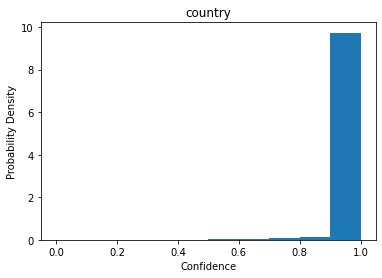

In [20]:
train_clf_and_create_reports(
    df_lume,
    'country',
    SCAN_ID_COL,
    RES_DIR,
    TODAY,
    CLIENT,
    COUNTRY,
    MIN_NUM_OF_SAMPLES,
    save_clf=SAVE_CLFS  
)

# gl_posting_id

In [16]:
df_lume['gl_posting_id'].value_counts(dropna=False)

40.0    61677
NaN     58383
50.0     5581
70.0        5
91.0        4
80.0        1
Name: gl_posting_id, dtype: int64

In [17]:
df_lume.dropna(subset=['gl_posting_id'], inplace=True)

In [18]:
df_lume["gl_posting_id"] = df_lume["gl_posting_id"].apply(lambda x: int(x))

In [19]:
df_lume.head()

,filename,text,country,gl_posting_id
0,000d3a2c37f81eda88f70ad52d38ce1c,gedruckt auf „steinbeis innojet premiui ausge...,de,40
1,000d3a2c37f81eda88f70adcd822ee1c,el: { n 1 )) } ad l dds conferencing & caterin...,de,40
2,000d3a2c37f81eda88f70ab0ea394e1c,zimmermann hauschild notare lubmin-brandov ga...,de,40
3,000d3a2c37f81eea8cd4c4aa57e474ed,rechnung uniper global commodities se rechnun...,de,40
4,000d3a2c37f81eda88f70aafcad7ee1c,= as fri it til vinr fre „> bundesnetzagent...,de,40


----------  start training for attribute: gl_posting_id  ---------- 

Reduced to 62601 samples from 2 relevant classes. (N=6)
Accuracy is 0.9879402603625909.

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

          40       0.99      1.00      0.99     11824
          50       0.95      0.83      0.88       697

    accuracy                           0.99     12521
   macro avg       0.97      0.91      0.94     12521
weighted avg       0.99      0.99      0.99     12521

----------  created histogram  ---------- 

----------  created word report  ---------- 



C:\Users\djourdain\Anaconda3\envs\uniper_py_38\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


----------  created predictions excel file  ---------- 

----------  saved clf to pkl and zip  ---------- 

----------  finished training for attribute: gl_posting_id  ----------


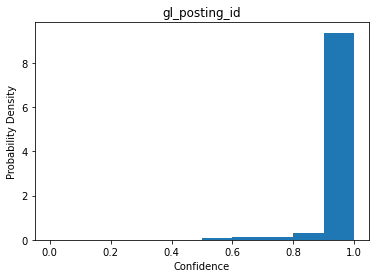

In [20]:
train_clf_and_create_reports(
    df_lume,
    'gl_posting_id',
    SCAN_ID_COL,
    RES_DIR,
    TODAY,
    CLIENT,
    COUNTRY,
    min_num_samples=6,  # set value so that only 40 and 50 remain as classes
    save_clf=SAVE_CLFS  
)